In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 8. In this exercise, we will generate simulated data, and will then use this data to perform best subset 
# selection.

# (a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector  of 
# length n = 100.

np.random.seed(1)

X = np.random.randn(100)
eps = np.random.randn(100)
X.shape


(100,)

In [3]:
# (b) Generate a response vector Y of length n = 100 according to the model Y = β0 + β1X + β2X2 + β3X3 + eps

# weights are of our choice
beta = [3,4,2,1]
Y = beta[0] + beta[1]*X + beta[2]*X**2 + beta[3]*X**3 + eps

In [4]:
poly = PolynomialFeatures(10, include_bias = False)
predictors = poly.fit_transform(pd.DataFrame({'X': X}))
predictors = pd.DataFrame(predictors)
col = ['X' + str(i) for i in range(1, 11)]
predictors.columns = col
predictors.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.624345,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436
1,-0.611756,0.374246,-0.228947,0.140060,-0.085683,0.052417,-0.032066,0.019617,-0.012001,0.007342
2,-0.528172,0.278965,-0.147342,0.077822,-0.041103,0.021710,-0.011466,0.006056,-0.003199,0.001689
3,-1.072969,1.151262,-1.235268,1.325403,-1.422116,1.525886,-1.637228,1.756694,-1.884878,2.022415
4,0.865408,0.748930,0.648130,0.560897,0.485404,0.420073,0.363534,0.314605,0.272262,0.235617


In [5]:
def fit_linear_reg(X, Y):
    # Fit LR model and return RSS and R-squared values
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    
    return model.ssr, model.rsquared, model

from tqdm import tnrange, tqdm_notebook
from itertools import combinations

def run_subset_selection(X, y):
    # initialization variables
    RSS_list, R_squared_list, feature_list = [], [], []
    aic_list, bic_list, adj_r_squared_list = [], [], []
    numb_features = []
    
    # Looping over k = 1 to k = 11 features in X
    for k in tnrange(1, len(X.columns) + 1, desc = 'Loop...'):
        best_features, best_RSS, best_r2, best_model = None, None, 0, None
        
        # Looping over all possible combinations
        for combo in combinations(X.columns, k):
            tmp_result = fit_linear_reg(X[list(combo)], Y) # store temp result
            r2 = tmp_result[1]
            
            if r2 > best_r2:
                best_features = combo
                best_RSS = tmp_result[0]
                best_r2 = tmp_result[1]
                best_model = tmp_result[2]
                
        RSS_list.append(best_RSS)
        R_squared_list.append(best_r2)
        feature_list.append(best_features)
        numb_features.append(len(best_features))
        aic_list.append(best_model.aic)
        bic_list.append(best_model.bic)
        adj_r_squared_list.append(best_model.rsquared_adj)
    
    # store in df
    df = pd.DataFrame({'numb_features': numb_features, 'RSS': RSS_list, 'R_squared': R_squared_list,
                      'AIC': aic_list, 'BIC': bic_list, 'adj_r2': adj_r_squared_list, 'features': feature_list})
    
    return df

In [6]:
best_subset_results = run_subset_selection(predictors, Y)

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [7]:
best_subset_results

,numb_features,RSS,R_squared,AIC,BIC,adj_r2,features
0,1,771.612854,0.819633,492.118982,497.329322,0.817793,"(X1,)"
1,2,329.558323,0.922965,409.046022,416.861533,0.921376,"(X1, X2)"
2,3,84.811563,0.980175,275.313877,285.734557,0.979556,"(X1, X2, X3)"
3,4,79.800246,0.981346,271.223347,284.249198,0.980561,"(X1, X2, X3, X6)"
4,5,79.446732,0.981429,272.779363,288.410385,0.980441,"(X1, X2, X3, X8, X10)"
5,6,77.901340,0.981790,272.815004,291.051195,0.980616,"(X1, X2, X5, X7, X8, X9)"
6,7,77.535196,0.981876,274.343886,295.185248,0.980497,"(X1, X2, X3, X5, X7, X9, X10)"
7,8,77.090698,0.981980,275.768950,299.215482,0.980396,"(X1, X2, X3, X4, X5, X6, X7, X9)"
8,9,76.794677,0.982049,277.384221,303.435923,0.980254,"(X1, X2, X4, X5, X6, X7, X8, X9, X10)"
9,10,76.498124,0.982118,278.997310,307.654182,0.980109,"(X1, X2, X3, X4, X5, X6, X7, X8, X9, X10)"


In [8]:
print('The best model according to adjR2 is model having features - ',
      best_subset_results.sort_values('adj_r2',ascending=False)['numb_features'].values[0],
     )
print('The best model according to AIC is model having features - ',
      best_subset_results.sort_values('AIC',ascending=True)['numb_features'].values[0])
print('The best model according to BIC is model having features - ',
      best_subset_results.sort_values('BIC',ascending=True)['numb_features'].values[0])

# we can see that using different metrics can give us different outcomes, althuohg what we will observe is that 
# AIC and BIC will give us similar results

The best model according to adjR2 is model having features -  6
The best model according to AIC is model having features -  4
The best model according to BIC is model having features -  4


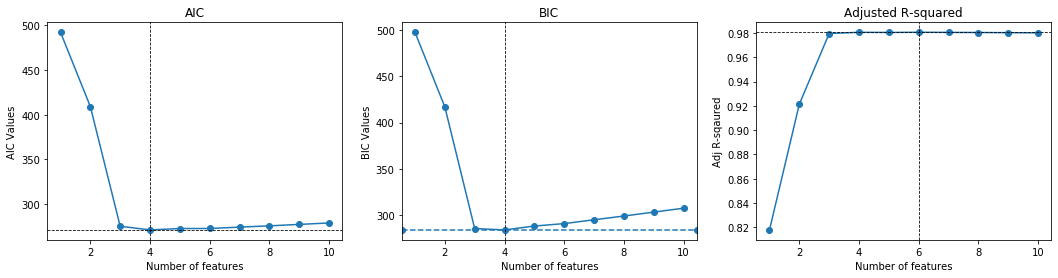

In [9]:
def plot_results(df):
    fig, (a1, a2, a3) = plt.subplots(1,3, figsize = (18, 4))
    a1.plot(df['numb_features'], df['AIC'], marker = 'o')
    a1.axhline(y = min(df['AIC']), linestyle = 'dashed', linewidth = 0.8, color = 'black')
    a1.axvline(x = df.sort_values('AIC', ascending = True)['numb_features'].values[0], color = 'black',
               linestyle = 'dashed', linewidth = 0.8)
    a1.set_title('AIC')
    a1.set_xlabel('Number of features')
    a1.set_ylabel('AIC Values')
    
    a2.plot(df['numb_features'], df['BIC'], marker = 'o')
    a2.axhline(y = min(df['BIC']), linestyle = 'dashed', marker = 'o')
    a2.axvline(x = df.sort_values('BIC', ascending = True)['numb_features'].values[0], color = 'black',
              linestyle = 'dashed', linewidth = 0.8)
    a2.set_title('BIC')
    a2.set_xlabel('Number of features')
    a2.set_ylabel('BIC Values')
    
    a3.plot(df['numb_features'], df['adj_r2'], marker = 'o')
    a3.axhline(y = max(df['adj_r2']), linestyle = 'dashed', linewidth = 0.8, color = 'black')
    a3.axvline(x = df.sort_values('adj_r2', ascending = False)['numb_features'].values[0], color = 'black',
               linestyle = 'dashed', linewidth = 0.8)
    a3.set_title('Adjusted R-squared')
    a3.set_xlabel('Number of features')
    a3.set_ylabel('Adj R-sqaured')

plot_results(best_subset_results)

In [10]:
print('Features choosen by AIC ',list(best_subset_results['features'][3]))
print('Features choosen by BIC ',list(best_subset_results['features'][3]))
print('Features choosen by adj_r2 ',list(best_subset_results['features'][6]))

Features choosen by AIC  ['X1', 'X2', 'X3', 'X6']
Features choosen by BIC  ['X1', 'X2', 'X3', 'X6']
Features choosen by adj_r2  ['X1', 'X2', 'X3', 'X5', 'X7', 'X9', 'X10']


In [19]:
# (d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your 
# answer compare to the results in (c)?

def forward_stepwise_selection(data, target):
    total_features = [[]]
    list_r2 = []
    list_adj_r2 = []
    list_aic,list_bic = [],[]
    len_features = []
    
    remaining_features = [col for col in data.columns if not col == target]
    for i in range(1, len(data.columns)):
        best_score = 0
        best_feature = None
        best_model = None
        
        for feature in remaining_features:
            X = total_features[i-1] + [feature]
            model = sm.OLS(data[target], sm.add_constant(data[X])).fit()
            score = model.rsquared
            if score > best_score:
                best_score = score
                best_feature = feature
                best_model = model
                
        total_features.append(total_features[i-1] + [best_feature])
        remaining_features.remove(best_feature)
        list_r2.append(best_model.rsquared)
        list_adj_r2.append(best_model.rsquared_adj)
        list_aic.append(best_model.aic)
        list_bic.append(best_model.bic)
        len_features.append(len(total_features[-1]))
            
    return pd.DataFrame({'numb_features': len_features, 'R_squared': list_r2, 'AIC': list_aic,
                            'BIC': list_bic, 'adj_r2': list_adj_r2, 'features': total_features[1:]})

In [20]:
data = pd.concat([predictors,pd.DataFrame(Y,columns = ['Y'])],axis = 1)
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,1.624345,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436,18.613080
1,-0.611756,0.374246,-0.228947,0.140060,-0.085683,0.052417,-0.032066,0.019617,-0.012001,0.007342,2.297027
2,-0.528172,0.278965,-0.147342,0.077822,-0.041103,0.021710,-0.011466,0.006056,-0.003199,0.001689,1.701394
3,-1.072969,1.151262,-1.235268,1.325403,-1.422116,1.525886,-1.637228,1.756694,-1.884878,2.022415,0.368960
4,0.865408,0.748930,0.648130,0.560897,0.485404,0.420073,0.363534,0.314605,0.272262,0.235617,7.512709


In [21]:
result_fwd = forward_stepwise_selection(data,'Y')

In [22]:
result_fwd

,numb_features,R_squared,AIC,BIC,adj_r2,features
0,1,0.819633,492.118982,497.329322,0.817793,[X1]
1,2,0.922965,409.046022,416.861533,0.921376,"[X1, X2]"
2,3,0.980175,275.313877,285.734557,0.979556,"[X1, X2, X3]"
3,4,0.981346,271.223347,284.249198,0.980561,"[X1, X2, X3, X6]"
4,5,0.981413,272.863273,288.494294,0.980425,"[X1, X2, X3, X6, X10]"
5,6,0.981497,274.414314,292.650506,0.980303,"[X1, X2, X3, X6, X10, X4]"
6,7,0.981718,275.210066,296.051427,0.980327,"[X1, X2, X3, X6, X10, X4, X8]"
7,8,0.981722,277.190336,300.636868,0.980115,"[X1, X2, X3, X6, X10, X4, X8, X9]"
8,9,0.981743,279.076446,305.128148,0.979917,"[X1, X2, X3, X6, X10, X4, X8, X9, X7]"
9,10,0.982118,278.997310,307.654182,0.980109,"[X1, X2, X3, X6, X10, X4, X8, X9, X7, X5]"


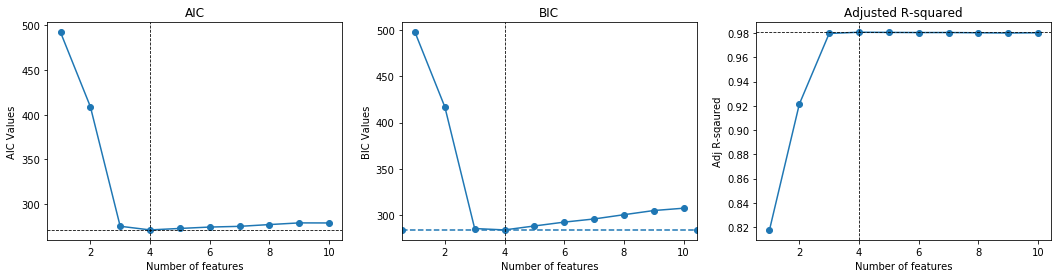

In [23]:
plot_results(result_fwd)

In [24]:
# in this case, best model is model with 4 features, for all the three metrics

In [30]:
def backward_stepwise_selection(data, target):
    features = [col for col in data.columns if not col == target]
    total_features = []
    list_r2 = []
    list_adj_r2 = []
    list_aic,list_bic = [],[]
    len_features = []
    
    while(len(features) > 0):
        features_with_constant = sm.add_constant(data[features])
        model = sm.OLS(data[target], features_with_constant).fit()
        max_p_value = model.pvalues[1:].max()
        total_features.append(features.copy())
        list_r2.append(model.rsquared)
        list_aic.append(model.aic)
        list_bic.append(model.bic)
        len_features.append(len(total_features[-1]))
        list_adj_r2.append(model.rsquared_adj)
        
        excluded_feature = model.pvalues[1:].idxmax()
        features.remove(excluded_feature) # remove feature with max p-value in each iteration
        
    return pd.DataFrame({'numb_features': len_features, 'R_squared':list_r2,
                      'AIC':list_aic,'BIC':list_bic,'adj_r2':list_adj_r2,'features':total_features})

In [31]:
result_bwd = backward_stepwise_selection(data,'Y')

In [32]:
result_bwd

,numb_features,R_squared,AIC,BIC,adj_r2,features
0,10,0.982118,278.997310,307.654182,0.980109,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10]"
1,9,0.982049,277.384221,303.435923,0.980254,"[X1, X2, X4, X5, X6, X7, X8, X9, X10]"
2,8,0.981940,275.989785,299.436317,0.980352,"[X1, X2, X4, X5, X6, X7, X8, X9]"
3,7,0.981844,274.521879,295.363241,0.980462,"[X1, X2, X4, X5, X6, X7, X9]"
4,6,0.981764,272.962058,291.198249,0.980587,"[X1, X2, X5, X6, X7, X9]"
5,5,0.980788,276.172489,291.803510,0.979766,"[X1, X2, X5, X6, X7]"
6,4,0.980037,278.006463,291.032314,0.979197,"[X1, X2, X5, X7]"
7,3,0.977367,288.559405,298.980086,0.976660,"[X1, X2, X5]"
8,2,0.922965,409.046022,416.861533,0.921376,"[X1, X2]"
9,1,0.819633,492.118982,497.329322,0.817793,[X1]


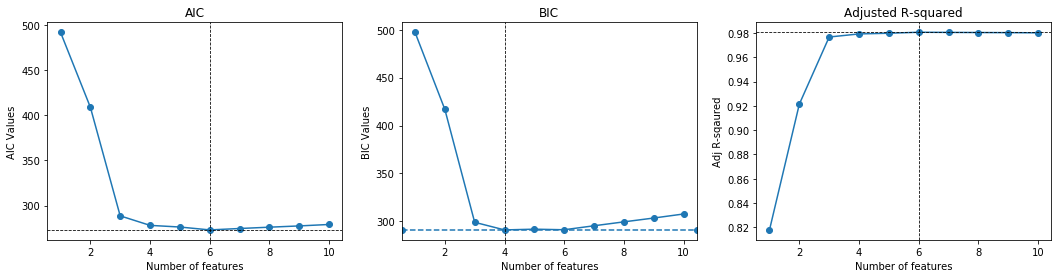

In [33]:
plot_results(result_bwd)

In [34]:
# (e) Now fit a lasso model to the simulated data, again using X, X2, ...,X10 as predictors. Use cross-validation
# to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. 
# Report the resulting coefficient estimates, and discuss the results obtained.


# predictors contain the dataframe for all the X's, response is stored in Y dataframe
predictors.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.624345,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436
1,-0.611756,0.374246,-0.228947,0.140060,-0.085683,0.052417,-0.032066,0.019617,-0.012001,0.007342
2,-0.528172,0.278965,-0.147342,0.077822,-0.041103,0.021710,-0.011466,0.006056,-0.003199,0.001689
3,-1.072969,1.151262,-1.235268,1.325403,-1.422116,1.525886,-1.637228,1.756694,-1.884878,2.022415
4,0.865408,0.748930,0.648130,0.560897,0.485404,0.420073,0.363534,0.314605,0.272262,0.235617


In [43]:
alpha_list = 10**np.linspace(-5,3,100)

In [46]:
def run_lasso(X, y, alpha_list):
    """
    Input - 
       X - predictors
       y - response
       alpha_list - list of parameter for lasso - alpha
    Returns - 
       coeff dict - dict of alpha - coeffs 
       cv_error_list - list of cross val errors
    """
    
    coeff_dict = {}
    cv_error_list = []
    for alpha in alpha_list:
        lasso = Lasso(alpha)
        lasso.fit(X, y)
        coeff_dict[alpha] = list(lasso.coef_)
        cv_error_list.append(-np.mean(cross_val_score(lasso, X, y, cv=10, scoring = 'neg_mean_squared_error')))
    return coeff_dict, cv_error_list

In [47]:
coeff_dict, cv_error_list = run_lasso(predictors, Y, alpha_list)

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.57639870738674, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.46944762366087, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.86560137199201, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.2055329633356, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.18731902153511, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.224041913835705, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.86352004223198, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.17677409535721, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.79926404751547, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.86220499586881, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.1756310999066, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.798327523699285, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.86076247702191, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.17437718820903, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.79730014614516, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.8591801003434, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.17300154122174, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.79617305813085, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.648594185282235, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.177645977786504, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.05397944119618, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22486704337623, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.6480023445967, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.1755772615018, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22505835978143, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.64735285508478, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.173307307870544, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.225267693042994, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.64664004985386, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.170816388467216, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22549665762464, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.645857694497295, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.16808280983494, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.6449989283124, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.165082711512845, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.04343612000808, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.644056198805345, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.161789842057885, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.04067055119937, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.179015966305414, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22632002404273, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.64302113279615, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.20510452803921, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.17780101867344, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22664693642081, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.205038670014396, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.17646709754394, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22700395716681, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.41118632439908, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.828405764701806, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.14621249003119, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.54148981582408, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.40540774175366, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.82465539695695, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.01933022679788, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.537135767570966, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.397578497221204, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.01525605490876, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.53334641306585, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.39079265709501, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.16885737524619, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.22900333121899, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.633509951430874, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.16664083398636, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.229573293566695, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.63143499270842, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.11854160832785, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.75157993430756, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.204367826167164, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.7888523999582, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.111686558190726, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.74597053438253, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.7802356056603, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.104150970876645, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.739805204434056, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.3242469327585, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.77076791945304, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.095862124599634, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.308968905939864, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.7603631741309, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.086748960441696, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.74892623299587, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.07672327590552, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.71737670436337, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.46587540805234, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.27418225770364, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.736352146031344, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.25444020578938, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.722523712929295, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.05354465853968, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.44091254574732, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.23296550596713, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.70731240094794, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.42650286773527, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.20962400979549, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.69057401558546, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.88202774062728, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.41061431909225, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.1842747166222, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.5837214242045, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.95215321948005, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.862823416457154, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.24273411548133, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.57655620022194, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.92738221397363, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.24434862828696, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.568637258070844, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.90000848453229, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.55987717601764, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.8697740410735, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.792000907189426, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.836309976182164, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.76309649040619, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.30291108659918, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.73100863578215, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.274119319992536, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.97714338548376, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.25165954508367, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.527497236170696, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.75824534127189, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.446288765463386, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.808093254957505, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.49839690603228, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.62061379962629, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.1760015605159, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.84904917159929, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.43837096280001, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.189609495254885, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.013716464854575, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.096048167886266, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.752600295724505, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.31177505377827, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.04454929309176, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.693986512254405, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.25360092249128, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.95599496865197, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.26252620476889, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.43114505643104, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.17636975476927, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.93070558859782, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.26402858973378, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.866765947672626, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.51030135059894, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.0543608264134, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.355275999008356, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.16848362601586, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.170280744256495, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.15939238646872, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.842808098085257, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.26585790246485, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.7870068978335, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.26446732740511, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.267152844198975, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.13646034860279, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.741059773345825, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.26195283527454, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.90485787498837, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.77168563671271, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.12357790916159, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.785395178327278, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.67683350269518, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.11143462047334, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.25075203374875, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.687539225796048, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.59913533001832, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.14243660001576, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.581657915323373, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.51528164709207, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.9801313633976, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.84167753352881, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.833153228051174, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.51436270619625, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.69413326257735, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.62671286215793, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.19706856780243, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.82773994111563, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.22203898892052, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.00011869873814, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.28116301861429, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.18077160244136, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.745600216008334, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.96778766731208, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.18876169663879, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.244045367242396, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.47425252397383, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.91966060540051, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.57878052421685, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.830661796053338, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.15884263061438, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.92421923347122, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.33367393761653, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.15907813039292, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.53717018119929, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.268109125246774, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.671669507538102, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.00425059718346, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.992947331966484, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.21186161954202, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.706796290209795, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.31547489952804, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.16605494852112, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.860340705001114, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.454180869174255, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.48858027744814, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.356938957001162, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.176627535086695, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.204191955411176, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.038311952264806, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.436748373242565, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.7949829314296, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.087075054015834, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.77106944989026, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.550870673877295, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.00895891432922, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.42791731656784, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.908943142337996, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.841902266535755, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.88814464403687, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.98890708876719, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.389106888673233, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.610357395648066, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.10641110412385, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.477109920392206, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.554819800047426, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.47863098066474, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.675794593483186, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.53717138253636, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.017641921125637, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.904045735267424, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.889584915374865, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.05507859982965, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.57036996671316, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.19998293132472, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.88537061673043, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.970824672793484, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.536924473147558, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.159830563442323, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.4419311608083, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.518313427052483, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.916420193339015, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.882749213058055, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.39344107926428, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.893521300623455, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.93240010875429, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.907162418467, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.879537471218452, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.77006181200138, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.839272875864527, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.33687335238726, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.824813326985655, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.642603767867826, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.736395246685593, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.029834334753524, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.774832606134652, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.783127856585637, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.890090030960206, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.734867325011727, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.497022291168705, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.010717049473392, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.496920544675568, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.093128199903283, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.50047207594694, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.633067461050523, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.43926553558618, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.70460291596736, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.19823334059744, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.35759683671884, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.507412063834856, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.91307506697121, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.979467235395568, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3314686611922326, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.558907664152343, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.285821997443872, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9118932976360696, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.533115119615886, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.978975416414116, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.86736507881077, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.707560091160325, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.53530930676618, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.297835941658832, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.855508290369144, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.233653648349748, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.31362448316281, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.229561020082095, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.480919665626352, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.14896059902546, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.905566238298526, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.065496046495795, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.94904127520661, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.31175830938868, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.606941292940803, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.664488801706522, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.70582284260495, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.882756770418467, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.41024740092624, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.334138415589337, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.523785996822099, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.12594722802389, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.021429693875433, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.003307676610348, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.815255106594329, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.625641601796076, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6820127552635284, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0030988040395528, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7010752501815176, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.235233398974508, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.511823503236208, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9677190332148768, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.003869409689031, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5955913917811984, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.382973330324177, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.134387688015188, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0043676092269465, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.031287964589374, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5426499343300861, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.371468930342978, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2381819417809652, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.682293807783523, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7135550206938035, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1923432934594445, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.398901943082663, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4283434505020125, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.651377290000241, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0048899179960813, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.96606572264416, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1069389726624337, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.22878528719599, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7160761626832794, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5253346369867131, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.528720746856393, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.77742283042606, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.830710658451622, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.580568190268437, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.161358857729908, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.656226070978917, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1642704643796122, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.284227889306393, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.59757163769109, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.608559034961885, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.553754111605613, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.996324863000737, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.142676507057274, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Object

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.98115165394161, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.995354852969086, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.09388821223675, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.411027346254045, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.661943506564256, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.726482542755136, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9713460932805447, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.578466863113505, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.341382738033445, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.00594267794531, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.36302315094224, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.350636200371554, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.266052325374602, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.30957412179609, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.12735713816426, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.129717226978869, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.710342476449767, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.634424623063694, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.839505057093703, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.501750839622872, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.555791590522432, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3946223456901521, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.175261584743936, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.65415883249946, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.838415337414375, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.161085807728995, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.169901333100029, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.74373071767903, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.374263542821325, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6411188458702384, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.451031817181416, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.940308397462957, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.143725915771427, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.228946750796666, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.74660925287864, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.46474111029232, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.10712795959003, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.2633080472973, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.76269234646162, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.91720611517064, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.41071210867375, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9481625245752525, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.716808855764384, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.01771705854827, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.71719732135654, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.9241123627923, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.471836164593356, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.797295431877984, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.4851397638555, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.44821188418393, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.49311139563395, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.64030633260694, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.90783492864091, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.89293396870238, tolerance: 0.4278019603903341
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.22738432686981, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.00361078975038, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.209538853479444, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.10333942880516, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.61626420509123, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.23114854313343, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.390719554978034, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.2176359107956, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.56778969674423, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.497665784383116, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.89374790151254, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.49593432572573, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.230349388533455, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.991036720761144, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.34920504557329, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.29226740688796, tolerance: 0.3060524076466068
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.5640844749114, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.574731745704412, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.546620724115087, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.508115216385022, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.646121944428728, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.310592341898882, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.021307954882673, tolerance: 0.3907288014113704
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.250412632040366, tolerance: 0.41265185424920947
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.224872599108267, tolerance: 0.39010026426124206
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.93888228543551, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.083097500636086, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.40037297009269, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.48517645887421, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.92486541687208, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.714225963604804, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.9567335353953, tolerance: 0.4189551438661615
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.364102122108307, tolerance: 0.4153074380774272
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.254318243339867, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4804582217107054, tolerance: 0.4181914807326185
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1636819264936094, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.045423621910459, tolerance: 0.3557536841335408
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44411896234441883, tolerance: 0.3320965944964175
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8773362441561403, tolerance: 0.40733603065102236
  positive)
/home/abhishek/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

In [48]:
# Analyzing the coefficients

tmp = pd.DataFrame(coeff_dict).T
tmp_index = alpha_list
tmp.head()

,0,1,2,3,4,5,6,7,8,9
0.000010,3.867722,1.716143,1.154603,-0.162165,0.013793,0.082873,-0.011304,-0.001404,0.001266,-0.00103
0.000010,3.867722,1.716135,1.154602,-0.162158,0.013794,0.082872,-0.011304,-0.001404,0.001266,-0.00103
0.000010,3.867723,1.716127,1.154600,-0.162151,0.013794,0.082870,-0.011304,-0.001404,0.001266,-0.00103
0.000011,3.867723,1.716118,1.154598,-0.162144,0.013795,0.082868,-0.011304,-0.001404,0.001266,-0.00103
0.000011,3.867723,1.716110,1.154597,-0.162136,0.013795,0.082866,-0.011304,-0.001404,0.001266,-0.00103


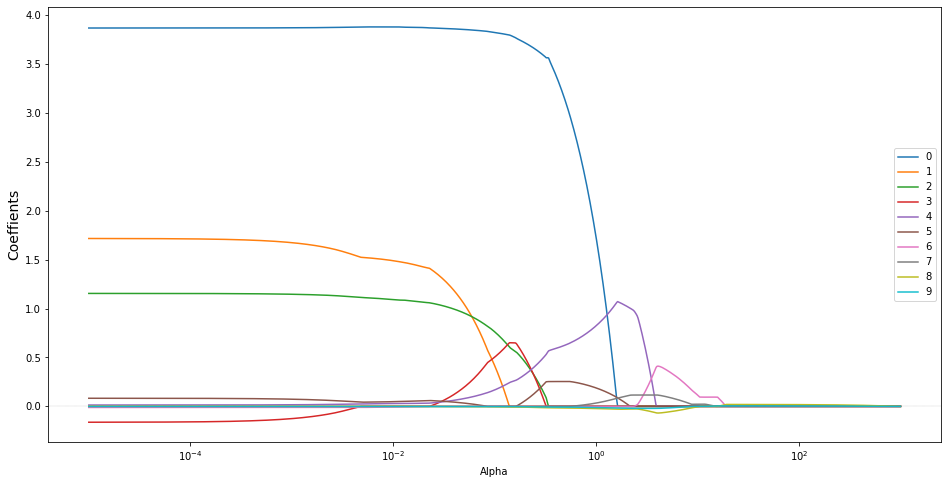

In [49]:
plt.figure(figsize = (16,8))
sns.lineplot(data = tmp, dashes=False)
plt.axhline(y = 0,linestyle = 'dashed',lw = 0.1,color = 'black')
plt.xticks(alpha_list)
plt.ylabel('Coeffients',fontsize = 14)
plt.xlabel('Alpha')
plt.legend(loc='right')
plt.xscale('log')

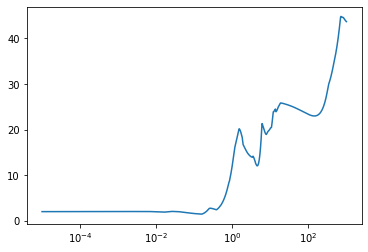

In [50]:
# Cross validation error
plt.plot(alpha_list,cv_error_list)
plt.xscale('log')